In [121]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from statsmodels.api import OLS
import numpy as np
import statsmodels.api as sm

In [122]:
# def calculate_half_life(spread):
#     df_spread = pd.DataFrame(spread, columns=['Spread'])
#     spread_lag = df_spread['Spread'].shift(1)
#     spread_lag.iloc[0] = spread_lag.iloc[1]
#     spread_return = df_spread['Spread'] - spread_lag
#     spread_return.iloc[0] = spread_return.iloc[1]
#     spread_lag2 = sm.add_constant(spread_lag)
#     model = sm.OLS(spread_return, spread_lag2)
#     res = model.fit()
#     half_life = round(-np.log(2) / res.params[1], 0)
#     return half_life

# calculate_half_life(data['Spread'])

In [123]:
# Step 1: Download Historical Data
xauusd = yf.download("GC=F", start="2019-01-01", end="2024-01-01")
xagusd = yf.download("SI=F", start="2019-01-01", end="2024-01-01")

# Prepare the data
data = pd.DataFrame({
    'Gold': xauusd['Adj Close']['GC=F'],
    'Silver': xagusd['Adj Close']['SI=F']
}).dropna()

del xauusd
del xagusd

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [124]:
# Step 2: Analyze Relationships
correlation = data.corr()
print(f"Correlation between Gold and Silver: {correlation.loc['Gold', 'Silver']}")

# Cointegration Test
score, p_value, _ = coint(data['Gold'], data['Silver'])
print(f"Cointegration p-value: {p_value}")

Correlation between Gold and Silver: 0.8319010117243449
Cointegration p-value: 0.668497624232878


### Calculate Hedge Ratio

In [125]:
xauusd = yf.download("GC=F", start="2022-01-01", end="2023-01-01")
xagusd = yf.download("SI=F", start="2022-01-01", end="2023-01-01")

# Prepare the data
data = pd.DataFrame({
    'Gold': xauusd['Adj Close']['GC=F'],
    'Silver': xagusd['Adj Close']['SI=F']
}).dropna()

del xauusd
del xagusd

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [126]:
# Step 3: Calculate the Spread
model = OLS(data['Gold'], data['Silver']).fit()
hedge_ratio = np.array(model.params)

### Calculate Spread

In [127]:
xauusd = yf.download("GC=F", start="2023-01-01", end="2024-01-01")
xagusd = yf.download("SI=F", start="2023-01-01", end="2024-01-01")

# Prepare the data
data = pd.DataFrame({
    'Gold': xauusd['Adj Close']['GC=F'],
    'Silver': xagusd['Adj Close']['SI=F']
}).dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [128]:
data['Spread'] = data['Gold'] - (hedge_ratio * data['Silver'])

In [129]:
# Standardize the Spread (Z-Score)
WINDOW = 30
mean_spread = data['Spread'].rolling(center=False, window=WINDOW).mean()
std_spread = data['Spread'].rolling(center=False, window=WINDOW).std()
data['Z-Score'] = (data['Spread'] - mean_spread) / std_spread

In [130]:
# Feature Engineering
data['Gold_Return'] = data['Gold'].pct_change()
data['Silver_Return'] = data['Silver'].pct_change()

# Lag Features
rolling_window = 21
THRESHOLD = 1.5
data['Z-Score_Lag'] = data['Z-Score'].shift(1)
data['Spread_Lag'] = data['Spread'].shift(1)
data['Spread_Std'] = data['Spread'].rolling(window=rolling_window).std()
data['Spread_MA'] = data['Spread'].rolling(window=rolling_window).mean()
data[f'Z-Score_Above_{THRESHOLD}'] = (data['Z-Score'] > THRESHOLD).astype(int)
data[f'Z-Score_Below_-{THRESHOLD}'] = (data['Z-Score'] < -THRESHOLD).astype(int)

data.dropna(inplace=True)

In [131]:
import pickle


features = [
    'Gold_Return', 'Silver_Return', 'Z-Score_Lag', 'Spread_Lag', 'Spread_Std', 'Spread_MA', f'Z-Score_Above_{THRESHOLD}',
    f'Z-Score_Below_-{THRESHOLD}'
]

test_data = data.copy()

test_data = test_data[features]

test_data.dropna(inplace=True)

model = pickle.load(open("model2.pkl", 'rb'))

# Load the scaler from the pickle file
with open('scaler.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)

# Use the loaded scaler to transform new data
X_new_scaled = loaded_scaler.transform(test_data)

data['Prediction'] = model.predict(X_new_scaled)


In [132]:
backtest_df = pd.DataFrame({
    "gold": data['Gold'],
    "silver": data['Silver'],
    "zscore": data['Z-Score'],
    "pred": data['Prediction']
    })

backtest_df['positions_Gold_Long'] = 0
backtest_df['positions_Silver_Long'] = 0
backtest_df['positions_Gold_Short'] = 0
backtest_df['positions_Silver_Short'] = 0

In [133]:
# Recall, we are trading the "synthetic pair" Gold/Silver and betting on its mean reversion

backtest_df.loc[(backtest_df.zscore >= 1) & (backtest_df.pred == 1), ('positions_Gold_Short', 'positions_Silver_Short')] = [-1, 1] # Short spread
backtest_df.loc[(backtest_df.zscore <= -1) & (backtest_df.pred == 1), ('positions_Gold_Long', 'positions_Silver_Long')] = [1, -1] # Buy spread
backtest_df.loc[(backtest_df.zscore <= 0), ('positions_Gold_Short', 'positions_Silver_Short')] = 0 # Exit short spread
backtest_df.loc[(backtest_df.zscore >= 0), ('positions_Gold_Long', 'positions_Silver_Long')] = 0 # Exit long spread

backtest_df.fillna(method='ffill', inplace=True) # ensure existing positions are carried forward unless there is an exit signal

/var/folders/k_/3s9bjxk17ss2bty8k9tjwjrc0000gn/T/ipykernel_8541/3346250024.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  backtest_df.fillna(method='ffill', inplace=True) # ensure existing positions are carried forward unless there is an exit signal


In [134]:
positions_Long = backtest_df[['positions_Gold_Long', 'positions_Silver_Long']]
positions_Short = backtest_df[['positions_Gold_Short', 'positions_Silver_Short']]
positions = np.array(positions_Long) + np.array(positions_Short)
positions = pd.DataFrame(positions, index=positions_Long.index, columns=['gold','silver'])

dailyret = backtest_df[['gold', 'silver']].pct_change() 
pnl = (positions.shift() * dailyret).sum(axis=1)

pnl[1:].sum()*100

np.float64(5.8228804115087796)

In [135]:
# PnL Calculation
# Shift the positions for the daily return calculation (positions taken on previous day)
daily_positions = positions.shift()  # shift positions one day back
daily_positions = daily_positions.fillna(0)  # Ensure there are no NaN values

# Calculate daily returns
dailyret = backtest_df[['gold', 'silver']].pct_change()

# Calculate PnL for the strategy
pnl = (daily_positions * dailyret).sum(axis=1)

# Total profit or loss percentage
total_pnl = pnl[1:].sum() * 100  # Don't include the first NaN value

total_pnl


np.float64(5.8228804115087796)

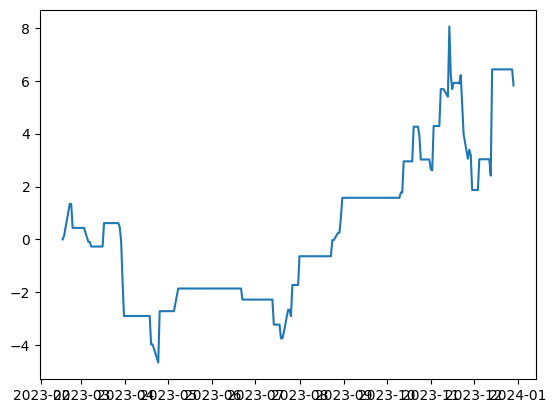

In [136]:
plt.plot(pnl[1:].cumsum()*100)
plt.show()

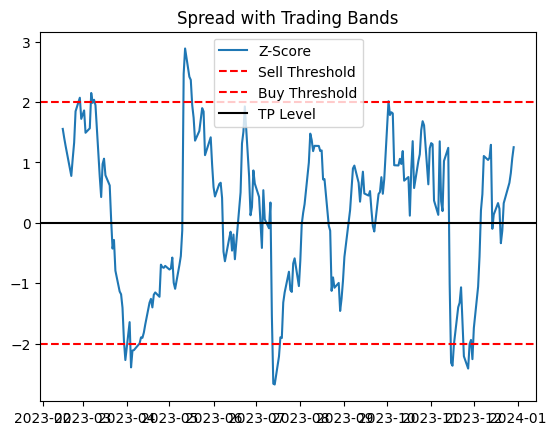

In [137]:
threshold = 2
plt.plot(backtest_df.zscore, label="Z-Score")
plt.axhline(threshold, color='red', linestyle='--', label='Sell Threshold')
plt.axhline(-threshold, color='red', linestyle='--', label='Buy Threshold')
plt.axhline(0, color='black', linestyle='-', label='TP Level')
plt.title('Spread with Trading Bands')
plt.legend()
plt.show()

In [138]:
from tabulate import tabulate

# Calculate cumulative returns
cumulative_returns = (1 + pnl).cumprod()

# Metrics calculations
start_value = cumulative_returns.iloc[0]
end_value = cumulative_returns.iloc[-1]
num_years = len(cumulative_returns) / 252  # Assuming 252 trading days per year

# CAGR (Compound Annual Growth Rate)
CAGR = ((end_value / start_value) ** (1 / num_years)) - 1

# Maximum Drawdown
drawdown = cumulative_returns / cumulative_returns.cummax() - 1
max_drawdown = drawdown.min()

# Standard Deviation
std_dev = pnl.std()

# Create a metrics table
metrics = [
    ["CAGR", f"{CAGR:.2%}"],
    ["Max Drawdown", f"{max_drawdown:.2%}"],
    ["Standard Deviation", f"{std_dev:.2%}"]
]

# Print with tabulate
print(tabulate(metrics, headers=["Metric", "Value"], tablefmt="grid"))

+--------------------+---------+
| Metric             | Value   |
+====================+=========+
| CAGR               | 6.50%   |
+--------------------+---------+
| Max Drawdown       | -6.06%  |
+--------------------+---------+
| Standard Deviation | 0.55%   |
+--------------------+---------+
